In [2]:
import numpy as np
from keras.applications import vgg16
from keras.layers import Dense, Dropout, Flatten
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import matplotlib.pyplot as plt

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory='./japanese_characters/Train', 
    target_size=(64,64), 
    color_mode='rgb', 
    batch_size=3, 
    class_mode='categorical', 
    shuffle=True, 
    seed=42)

valid_generator = test_datagen.flow_from_directory(
    directory='./japanese_characters/Valid', 
    target_size=(64,64), 
    color_mode='rgb', 
    batch_size=2, 
    class_mode='categorical', 
    shuffle=True, 
    seed=42)

test_generator = test_datagen.flow_from_directory(
    directory='./japanese_characters/Test', 
    target_size=(64,64), 
    color_mode='rgb', 
    batch_size=1, 
    class_mode=None, 
    shuffle=False, 
    seed=42)

Found 92 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 20 images belonging to 1 classes.


In [5]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [6]:
train_generator.n, valid_generator.n

(92, 40)

In [7]:
STEP_SIZE_TRAIN, STEP_SIZE_VALID

(30, 20)

In [76]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [77]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)        
x = Dense(128, activation='relu')(x)        
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

In [78]:
x

<tf.Tensor 'dropout_6/cond/Merge:0' shape=(?, 128) dtype=float32>

In [79]:
predictions

<tf.Tensor 'dense_18/Softmax:0' shape=(?, 2) dtype=float32>

In [80]:
base_model.output

<tf.Tensor 'block5_pool_4/MaxPool:0' shape=(?, 2, 2, 512) dtype=float32>

In [81]:
base_model.input

<tf.Tensor 'input_5:0' shape=(?, 64, 64, 3) dtype=float32>

In [82]:
# Define trainable model which links input from the base model to the new classification prediction layers
model = Model(inputs=base_model.input, outputs=predictions)

In [83]:
for layer in base_model.layers:
    layer.trainable = False

In [84]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5)

Epoch 1/5
30/30 [==============================] - 2s 73ms/step - loss: 3.7372 - acc: 0.6556 - val_loss: 3.6138 - val_acc: 0.7000
Epoch 2/5
30/30 [==============================] - 1s 50ms/step - loss: 1.6959 - acc: 0.8390 - val_loss: 1.4226 - val_acc: 0.8750
Epoch 3/5
30/30 [==============================] - 2s 50ms/step - loss: 1.3580 - acc: 0.8501 - val_loss: 2.9306 - val_acc: 0.8000
Epoch 4/5
30/30 [==============================] - 2s 51ms/step - loss: 1.5671 - acc: 0.8501 - val_loss: 1.3593 - val_acc: 0.8750
Epoch 5/5
30/30 [==============================] - 2s 55ms/step - loss: 0.7968 - acc: 0.9333 - val_loss: 1.0134 - val_acc: 0.9250


In [87]:
score = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
print('Score:', score)

Score: [0.3554503619670868, 0.975]


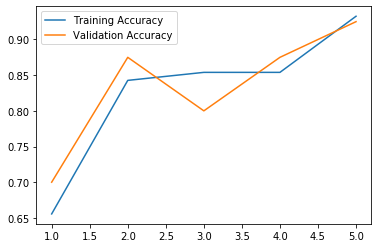

In [88]:
# Plot data to see relationships in training and validation data
epoch_list = list(range(1, len(hist.history['acc']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist.history['acc'], epoch_list, hist.history['val_acc'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))

In [89]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
STEP_SIZE_TEST

20

In [90]:
test_generator.reset()

In [91]:
pred = model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
pred

20/20 [==============================] - 0s 23ms/step


array([[2.6950468e-03, 9.9730492e-01],
       [1.0000000e+00, 1.4967864e-11],
       [1.0000000e+00, 1.2301988e-16],
       [1.0000000e+00, 3.1804190e-30],
       [9.7935557e-12, 1.0000000e+00],
       [1.0000000e+00, 1.5638670e-17],
       [1.0000000e+00, 1.9882616e-13],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.7420323e-25],
       [1.0000000e+00, 2.1077885e-16],
       [2.2385381e-10, 1.0000000e+00],
       [1.7414077e-10, 1.0000000e+00],
       [7.0832520e-15, 1.0000000e+00],
       [1.5290860e-17, 1.0000000e+00],
       [9.9874675e-01, 1.2532562e-03],
       [7.7899509e-28, 1.0000000e+00],
       [4.3598594e-13, 1.0000000e+00],
       [1.5996852e-03, 9.9840027e-01],
       [1.9042055e-17, 1.0000000e+00],
       [1.7851213e-03, 9.9821496e-01]], dtype=float32)

In [94]:
predicted_class_indices = np.argmax(pred, axis=1)
predicted_class_indices

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [97]:
labels = (train_generator.class_indices)
labels

{'Hiragana': 0, 'Katakana': 1}

In [99]:
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print('predictions for test images', predictions)

predictions for test images ['Katakana', 'Hiragana', 'Hiragana', 'Hiragana', 'Katakana', 'Hiragana', 'Hiragana', 'Hiragana', 'Hiragana', 'Hiragana', 'Katakana', 'Katakana', 'Katakana', 'Katakana', 'Hiragana', 'Katakana', 'Katakana', 'Katakana', 'Katakana', 'Katakana']


<b>actual_test_labels: </b>
* first 10 images Hiragana
* next 10 images Katakana

In [107]:
actual_test_labels = np.concatenate((np.full(10, 0), np.full(10, 1)), axis=0)
actual_test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [108]:
from sklearn.metrics import accuracy_score

accuracy_score(actual_test_labels, predicted_class_indices)

0.85

In [109]:
from sklearn.metrics import confusion_matrix

confusion_matrix(actual_test_labels, predicted_class_indices)

array([[8, 2],
       [1, 9]])